## Aim of the algorithm

This algorithm aims for the computation of the evolution/emergence of altruism in a population composed of breeders, offspring and waiters. To do so, we set some parameters and compute the evolution of the eigenvalues in function of the altruism parameter, h_x/eta_x and on the value of some parameters depending on the experiments.

### Libraries

In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using Profile
using Random
using CSV
using DataFrames


Parameters

In [69]:
#survivals:
s_u = 0.5
s_x = 0.7
s_y = 0.7
s_jx = 0.5
s_jy = 0.5

#fecundity
b_x = 3
b_y = 3
phi = 0.1
M = 1

#altruism
h_x = 0
h_y = 0
alpha = 1
beta = 1
h_x_bar = h_x
h_y_bar = h_y

T_x(h_x_bar) = 1-exp(-b_x*h_x_bar)
T_y(h_y_bar) = exp(-b_y*h_y_bar)

theta_x(x,y) = (1-phi)*x/(x+y)
theta_y(x,y) = (1-phi)*y/(x+y) 
psi_x(x,y) = theta_x(x,y)+1+phi
psi_y(x,y) = theta_y(x,y)+1+phi


#competition
a = 0.05
p_u = 0.5
p_u_tilde(x,y) = p_u/(1+a*(x+y))
p_j = 0.5
p_j_tilde(x,y) = p_j/(1+a*(x+y))

parameters = Dict("b_x"=>b_x,"b_y"=>b_y,"s_u"=>s_u,"s_jx"=>s_jx,"s_jy"=>s_jy,"s_x"=>s_x,"s_y"=>s_y,"phi"=>phi,"M"=>M,"a"=>a,"p_u"=>p_u,"p_j"=>p_j,"h_x" =>h_x,"h_x_bar" =>h_x_bar,"h_y" =>h_y, "h_y_bar" =>h_y_bar)

#time
t_0 = 0
t_max = 100

#Relatedness
R_jp = 1/2*(1+phi)
R_mates = ((b_x-1)*phi^2+(1-phi)^2*(1/4+1/(4*M))+1)/b_x;


Matrices definitions

In [3]:
# Wild type matrix
function A(x,y,parameters) 
    
    b_x = parameters["b_x"]
    b_y = parameters["b_y"]
    s_u = parameters["s_u"]
    s_jx = parameters["s_jx"]
    s_jy = parameters["s_jy"]
    s_x = parameters["s_x"]
    s_y = parameters["s_y"]
    p_u = parameters["p_u"]
    p_j = parameters["p_j"]
    a = parameters["a"]
    M = parameters["M"]
    phi = parameters["phi"]
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    p_u_tilde(x,y) = p_u/(1+a*(x+y))
    p_j_tilde(x,y) = p_j/(1+a*(x+y))
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    
    return [s_u*(1-p_u_tilde(x,y)) 0 0 (1-h_x)*s_u*(1-p_u_tilde(x,y))+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*(1-p_j_tilde(x,y)) (1-h_y)*s_u*(1-p_u_tilde(x,y))+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*(1-p_j_tilde(x,y))
    ; s_u*p_u_tilde(x,y) (1-T_x(h_x_bar))*s_x T_y(h_y_bar)*s_x (1-h_x)*s_u*p_u_tilde(x,y)+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y) (1-h_y)*s_u*p_u_tilde(x,y)+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar)*s_jy))*p_j_tilde(x,y)
    ; 0 T_x(h_x_bar)*s_y (1-T_y(h_y_bar))*s_y 0 0
    ; s_u*p_u_tilde(x,y)*b_x (1-T_x(h_x_bar))*s_x*b_x T_y(h_y_bar)*s_x*b_x (1-h_x)*s_u*p_u_tilde(x,y)*b_x+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y)*b_x (1-h_y)*s_u*p_u_tilde(x,y)*b_x+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*p_j_tilde(x,y)*b_x
    ; 0 T_x(h_x_bar)*s_y*b_y (1-T_y(h_y_bar))*s_y*b_y 0 0
    ];
end

# Mutant matrix
function Mutant(x,y,parameters) 
    
    b_x = parameters["b_x"]
    b_y = parameters["b_y"]
    s_u = parameters["s_u"]
    s_jx = parameters["s_jx"]
    s_jy = parameters["s_jy"]
    s_x = parameters["s_x"]
    s_y = parameters["s_y"]
    p_u = parameters["p_u"]
    p_j = parameters["p_j"]
    a = parameters["a"]
    p_u_tilde(x,y) = p_u/(1+a*(x+y))
    p_j_tilde(x,y) = p_j/(1+a*(x+y))
    M = parameters["M"]
    phi = parameters["phi"]
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    return [s_u*(1-p_u_tilde(x,y)) 0 0 (1-h_x)*s_u*(1-p_u_tilde(x,y))+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*(1-p_j_tilde(x,y)) (1-h_y)*s_u*(1-p_u_tilde(x,y))+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*(1-p_j_tilde(x,y))
    ; s_u*p_u_tilde(x,y) (1-T_x(h_x_bar))*s_x T_y(h_y_bar)*s_x (1-h_x)*s_u*p_u_tilde(x,y)+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y) (1-h_y)*s_u*p_u_tilde(x,y)+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*p_j_tilde(x,y)
    ; 0 T_x(h_x_bar)*s_y (1-T_y(h_y_bar))*s_y 0 0
    ; s_u*p_u_tilde(x,y)*b_x/2*psi_x(x,y) (1-T_x(h_x_bar))*s_x*b_x/2*psi_x(x,y)+T_x(h_x_bar)*s_y*b_x/2*theta_x(x,y) T_y(h_y_bar)*s_x*b_x/2*psi_x(x,y)+(1-T_y(h_y_bar))*s_y*b_x/2*theta_x(x,y) (1-h_x)*s_u*p_u_tilde(x,y)*b_x/2*psi_x(x,y)+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y)*b_x/2*psi_x(x,y) (1-h_y)*s_u*p_u_tilde(x,y)*b_x/2*psi_x(x,y)+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*p_j_tilde(x,y)*b_x/2*psi_x(x,y)
    ; s_u*p_u_tilde(x,y)*b_y/2*theta_y(x,y) (1-T_x(h_x_bar))*s_x*b_y/2*theta_y(x,y)+T_x(h_x_bar)*s_y*b_y/2*psi_y(x,y) T_y(h_y_bar)*s_x*b_y/2*theta_y(x,y)+(1-T_y(h_y_bar))*s_y*b_y/2*psi_y(x,y) (1-h_x)*s_u*p_u_tilde(x,y)*b_y/2*theta_y(x,y)+h_x*(T_x(h_x_bar)*s_jy+(1-T_x(h_x_bar))*s_jx)*p_j_tilde(x,y)*b_y/2*theta_y(x,y) (1-h_y)*s_u*p_u_tilde(x,y)*b_y/2*theta_y(x,y)+h_y*(T_y(h_y_bar)*s_jx+(1-T_y(h_y_bar))*s_jy)*p_j_tilde(x,y)*b_y/2*theta_y(x,y)
    ];
end;

function equilibrium_mu(parameters)
    mu = rand!(zeros(5,1))
    while sum(abs.(mu - A(mu[2], mu[3],parameters)*mu)) >0.00001
        mu = A(mu[2], mu[3],parameters)*mu
    end
    return mu
end;

function equilibrium_nu(parameters,mu)
    nu = rand!(zeros(1,5))
    while sum(abs.(nu - nu*A(mu[2], mu[3],parameters))) >0.00001
        nu = nu*A(mu[2], mu[3],parameters)/sum(nu)
    end
    return nu
end;


function R_0(parameters)
    b_x = parameters["b_x"]
    b_y = parameters["b_y"]
    s_u = parameters["s_u"]
    s_jx = parameters["s_jx"]
    s_jy = parameters["s_jy"]
    s_x = parameters["s_x"]
    s_y = parameters["s_y"]
    p_u = parameters["p_u"]
    p_j = parameters["p_j"]
    a = parameters["a"]
    p_u_tilde(x,y) = p_u/(1+a*(x+y))
    p_j_tilde(x,y) = p_j/(1+a*(x+y))
    M = parameters["M"]
    phi = parameters["phi"]
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    nu_u = 1
    nu_jx = (1 - h_x) + h_x*((1 − T_x(h_x_bar))*s_jx + T_x(h_x_bar)*s_y )*(1 − p_j+1 − p_j*(1-s_u*(1-p_u))/s_u/p_u)
    nu_jy = (1 - h_y) + h_y*((1 − T_y(h_y_bar))*s_jy + T_y(h_y_bar)*s_jx )*(1 − p_j+1 − p_j*(1-s_u*(1-p_u))/s_u/p_u)
    nu_y = 1/(1-s_y*(1-T_y(h_y_bar)))*(((1-T_y(h_y_bar))*s_y*b_y)+T_y(h_y_bar)*s_x*(1-s_u*(1-p_u))/s_u/p_u)
    nu_x = (1-T_x(h_x_bar))*s_x*(1-s_u*(1-p_u))/s_u/p_u+T_x(h_x_bar)*s_y*(nu_y+b_y*nu_jy)
    R_0 = s_u*(1-p_u)*nu_u+s_u*p_u*(nu_x+b_x*nu_jx)
    return R_0
end
println(R_0(parameters))

1.375


Equilibrium checkpoint

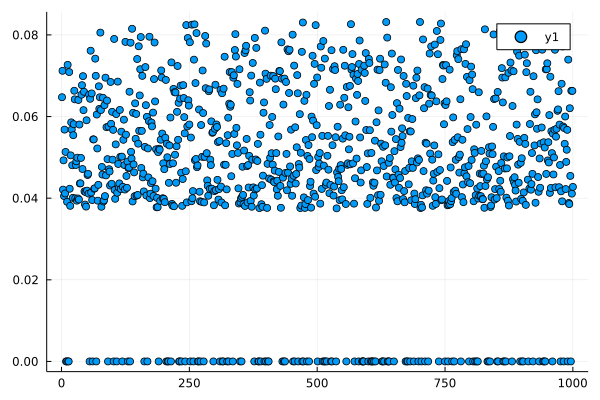

In [14]:
i = 0
N = 1000
R_0_v = zeros(N)
eq_v = zeros(N)
eq_x = zeros(N)
P = zeros(N)
for i in range(1,N)
    parameters["b_x"] = 3+rand(1)[1]*5
    #parameters["p_u"] = rand(1)[1]
    parameters["s_u"] = 0.5#rand(1)[1]
    parameters["s_x"] = 0.7
    p = parameters["p_u"]
    eq = equilibrium_mu(parameters)
    if R_0(parameters)>1
        P[i] = parameters["s_u"]*p/(1+a*(eq[2]+eq[3]))/(1-parameters["s_u"]*(1-p/(1+a*(eq[2]+eq[3]))))
    end
    
end
scatter(P)



Fitness computations

In [4]:
function hamilton(parameters,nu,mu)   
    b_x = parameters["b_x"]
    b_y = parameters["b_y"]
    s_u = parameters["s_u"]
    s_jx = parameters["s_jx"]
    s_jy = parameters["s_jy"]
    s_x = parameters["s_x"]
    s_y = parameters["s_y"]
    p_u = parameters["p_u"]
    p_j = parameters["p_j"]
    a = parameters["a"]
    M = parameters["M"]
    phi = parameters["phi"]
    h_x = parameters["h_x"]
    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    p_u_tilde(x,y) = p_u/(1+a*(x+y))
    p_j_tilde(x,y) = p_j/(1+a*(x+y))
    h_x = parameters["h_x"]

    h_y = parameters["h_y"]
    h_x_bar = parameters["h_x_bar"]
    h_y_bar = parameters["h_y_bar"]
    if parameters["h_x"] < 0
        parameters["h_x"] = 0
        parameters["h_x_bar"] = 0
    end
    if parameters["h_y"] < 0
        parameters["h_y"] = 0
        parameters["h_y_bar"] = 0
    end
    hamilton_indiv_x = -mu[4]*(s_u*(1-p_u_tilde(mu[2],mu[3]))*nu[1]+s_u*(p_u_tilde(mu[2],mu[3]))*((nu[3]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])))-(T_x(parameters["h_x_bar"])*s_jy+(1-T_x(parameters["h_x_bar"]))*s_jx)*((1-p_j_tilde(mu[2],mu[3]))*nu[1]+p_j_tilde(mu[2],mu[3])*(nu[3]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5]))))
    hamilton_parent_x = mu[2]*R_jp*b_x*(1-T_x(parameters["h_x_bar"]))*(s_y*nu[3]-s_x*nu[2]+s_y*((1+phi)*b_y/2*nu[5]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])-s_x*((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5]))
    hamilton_mates_x = b_x*h_x*R_mates*mu[4]*(1-T_x(h_x_bar))*(s_jy-s_jx)*((1-p_j_tilde(mu[2],mu[3]))*nu[1]+p_j_tilde(mu[2],mu[3])*(nu[2]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])))
    hamilton_x = hamilton_indiv_x+hamilton_parent_x+hamilton_mates_x
    
    hamilton_indiv_y = -b_y*(s_u*(1-p_u_tilde(mu[2],mu[3]))*nu[1]+s_u*(p_u_tilde(mu[2],mu[3]))*((nu[3]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])))-(T_y(parameters["h_y_bar"])*s_jx+(1-T_y(parameters["h_y_bar"]))*s_jy)*((1-p_j_tilde(mu[2],mu[3]))*nu[1]+p_j_tilde(mu[2],mu[3])*(nu[3]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5]))))
    hamilton_parent_y = R_jp*b_y*(T_y(parameters["h_y_bar"]))*(s_y*nu[3]-s_x*nu[2]+s_y*((1+phi)*b_y/2*nu[5]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])-s_x*((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5]))
    hamilton_mates_y = b_y*h_y*R_mates*b_y*(T_y(h_y_bar))*(s_jy-s_jx)*((1-p_j_tilde(mu[2],mu[3]))*nu[1]+p_j_tilde(mu[2],mu[3])*(nu[2]+((1+phi)*b_x/2*nu[4]+(1-phi)*b_x/2*mu[2]/(mu[2]+mu[3])*nu[4]+(1-phi)*b_y/2*mu[3]/(mu[2]+mu[3])*nu[5])))
    hamilton_y = hamilton_indiv_y+hamilton_parent_y+hamilton_mates_y
    #println("indiv",hamilton_indiv_x)
    #println("parent",hamilton_parent_x)
    #println("mates",hamilton_mates_x)
    #println(mu[3])
    return hamilton_x>0, hamilton_y>0
end


hamilton (generic function with 1 method)

Computation of dW_x

In [17]:
function Fitness_comput(parameters)
    d_hx = 0.01
    d_hx_bar = 0.01
    d_hy = 0.01
    d_hy_bar = 0.01
    dW_x = 0
    dW_y = 0
    # Find eigenvectors: mu, nu
    if R_0(parameters)>1.1
        mu = equilibrium_mu(parameters)
        nu = equilibrium_nu(parameters, mu)

        # h_x, h_x_bar
        parameters["h_x"] += d_hx
        W_indiv_hx_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]
        parameters["h_x"] -= 2*d_hx
        W_indiv_hx_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]

        parameters["h_x"] += d_hx
        parameters["h_x_bar"] +=d_hx_bar
    # changing right eigenvector
        W_parent_hx_up = nu*Mutant(mu[2], mu[3],parameters)*[0,mu[2],0,0,0]
        W_mates_hx_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]
        
        parameters["h_x_bar"] -= 2*d_hx_bar
        W_parent_hx_down = nu*Mutant(mu[2], mu[3],parameters)*[0,mu[2],0,0,0]
        W_mates_hx_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,b_x*mu[2],0]
        
        parameters["h_x_bar"] +=d_hx_bar


        W_indiv_hx = W_indiv_hx_up-W_indiv_hx_down
        W_parent_hx = R_jp*(W_parent_hx_up-W_parent_hx_down)
        W_mates_hx = R_mates*(W_mates_hx_up-W_mates_hx_down)
        dW_x = W_parent_hx[1]+W_indiv_hx[1]+W_mates_hx[1]

        # h_y, h_y_bar

        parameters["h_y"] += d_hy
        W_indiv_hy_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]
        parameters["h_y"] -= 2*d_hy
        W_indiv_hy_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]

        parameters["h_y"] += d_hy
        parameters["h_y_bar"] += d_hy_bar
        W_parent_hy_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,mu[3],0,0]
        W_mates_hy_up = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]

        parameters["h_y_bar"] -= 2*d_hy_bar
        W_parent_hy_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,mu[3],0,0]
        W_mates_hy_down = nu*Mutant(mu[2], mu[3],parameters)*[0,0,0,0,b_y*mu[3]]
        parameters["h_y_bar"] += d_hy_bar


        W_indiv_hy = W_indiv_hy_up-W_indiv_hy_down
        W_parent_hy = R_jp*(W_parent_hy_up-W_parent_hy_down)
        W_mates_hy = R_mates*(W_mates_hy_up-W_mates_hy_down)
        #println(W_mates_hx_up, "  ", W_mates_hx_down)
        #println(parameters["h_x"],"  ",parameters["h_x_bar"],"  ",parameters["h_y"],"  ",parameters["h_y_bar"],"  ")
        #println( W_parent_hx,"  ",W_indiv_hx,"  ",W_mates_hx)
        dW_y = W_parent_hy[1]+W_indiv_hy[1]+W_mates_hy[1]
    end  
    return dW_x, dW_y
   
    
end;
x = 0.01
parameters["h_x"] = x
parameters["h_y"] = x
parameters["h_x_bar"] = x
parameters["h_y_bar"] = x
@time(Fitness_comput(parameters))


  0.617964 seconds (1.65 M allocations: 89.950 MiB, 3.06% gc time, 99.25% compilation time)


(0.5963766751945457, 0.01674847091368725)

In [18]:
h_x = 0
h_y = 0
h_x_bar = h_x
h_y_bar = h_y

parameters = Dict("b_x"=>b_x,"b_y"=>b_y,"s_u"=>s_u,"s_jx"=>s_jx,"s_jy"=>s_jy,"s_x"=>s_x,"s_y"=>s_y,"phi"=>phi,"M"=>M,"a"=>a,"p_u"=>p_u,"p_j"=>p_j,"h_x" =>h_x,"h_x_bar" =>h_x_bar,"h_y" =>h_y, "h_y_bar" =>h_y_bar)
parameters["a"] = 0.4
parameters["s_u"] = 0.5
parameters["s_jx"] = 0.5*0.9
parameters["s_jy"] = 0.5*0.9
parameters["h_x"] = 0
parameters["h_y"] = 0
parameters["h_x_bar"] = 0
parameters["h_y_bar"] = 0
function ESS(parameters)
    dW_x = 1
    dW_y = 1
    i=0
    h_x_mem = 1
    h_y_mem = 1
    reason = "ess found"
    while abs(dW_x) > 1e-5 || abs(dW_y) > 1e-5
      
        i += 1
        #If taking too much time
        if i > 20000
            reason = "i>100000"
            break
        end
        
        
        #Same values previously computed
        if parameters["h_x"]==h_x_mem && parameters["h_y"]==h_y_mem
            reason = "stagnation"
            break
        end
        
        if R_0(parameters)<1.1
            break
        end
        
        dW_x,dW_y = Fitness_comput(parameters)
        
        #Loading previous values
        h_x_mem = parameters["h_x"]
        h_y_mem = parameters["h_y"]
    
        #New values
        parameters["h_x"] += dW_x
        parameters["h_x_bar"] += dW_x
        
        parameters["h_y"] += dW_y
        parameters["h_y_bar"] += dW_y
        
        #Boundaries conditions
        parameters["h_x"] = clamp(parameters["h_x"],0,1)
        parameters["h_y"] = clamp(parameters["h_y"],0,1)
        parameters["h_x_bar"] = parameters["h_x"]
        parameters["h_y_bar"] = parameters["h_y"]
    end
        
    parameters["h_x"] = clamp(parameters["h_x"],0,1)
    parameters["h_y"] = clamp(parameters["h_y"],0,1)
    parameters["h_x_bar"] = parameters["h_x"]
    parameters["h_y_bar"] = parameters["h_y"]
    return parameters

end
@time(ESS(parameters))

println(parameters)
println("h_x = ", parameters["h_x"])
println("h_y = ", parameters["h_y"])

 89.174861 seconds (1.16 G allocations: 40.134 GiB, 5.16% gc time, 0.05% compilation time)
Dict{String, Real}("s_u" => 0.5, "h_x_bar" => 1.0, "h_x" => 1.0, "p_u" => 0.5, "s_y" => 0.7, "a" => 0.4, "h_y_bar" => 0.7589115862492608, "M" => 1, "s_jx" => 0.45, "phi" => 0.1, "b_x" => 3, "h_y" => 0.7589115862492608, "b_y" => 4, "s_jy" => 0.45, "s_x" => 0.5, "p_j" => 0.5)
h_x = 1.0
h_y = 0.7589115862492608


In [6]:
function ESS_v(parameters)
    
    i = 1
    ess_x_v = zeros(N)
    ess_y_v = zeros(N)
    ess_x_v2 = zeros(N)
    ess_y_v2 = zeros(N)
    x_v = zeros(N)
    x_v2 = zeros(N)
    evol_parent = zeros(N)
    evol_parent = zeros(N)
    evol_parent2 = zeros(N)
    evol_indiv = zeros(N)
    evol_indiv2 = zeros(N)
    evol_mates = zeros(N)
    evol_mates2 = zeros(N)


    for i in range(1,N)
        x = i*0.6/N+0.2
        parameters["a"] = 0.4
        parameters["s_u"] = x
        parameters["s_jx"] = x-0.1
        parameters["s_jy"] = x-0.1
        
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        
        if R_0(parameters)>1.1
            
            parameters = ESS(parameters)

            
        end
        x_v[i] = x
        ess_x_v[i] = parameters["h_x"]
        
        ess_y_v[i] = parameters["h_y"]
       
        
    end
    
    for i in range(1,N)
        
        x = i*0.6/N+0.2
        parameters["a"] = 0.8
        parameters["s_u"] = x
        parameters["s_jx"] = x-0.1
        parameters["s_jy"] = x-0.1
        
        parameters["h_x"] = 0.5
        parameters["h_y"] = 0.5
        parameters["h_x_bar"] = 0.5
        parameters["h_y_bar"] = 0.5
        
        if R_0(parameters)>1.1
            mu = equilibrium_mu(parameters)
            nu = equilibrium_nu(parameters,mu)
    
            parameters = ESS(parameters)

           
            
        end        
        x_v2[i] = x
        ess_x_v2[i] = parameters["h_x"]

        ess_y_v2[i] = parameters["h_y"]
    end
    
    return ess_x_v, ess_y_v, ess_x_v2, ess_y_v2, x_v, x_v2
end



ESS_v (generic function with 1 method)

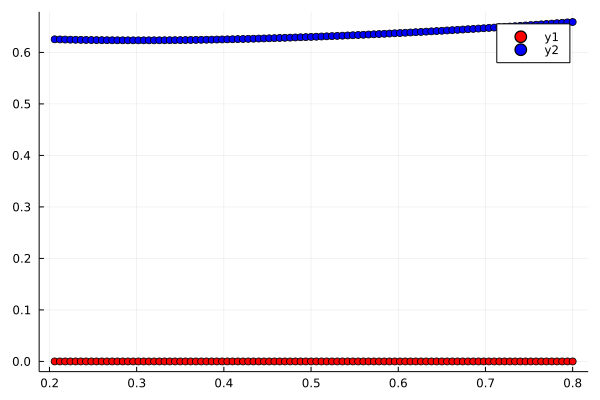

In [72]:
N = 100

ess_x_v, ess_y_v, ess_x_v2, ess_y_v2, x_v, x_v2 = ESS_v(parameters)
#println(ess_x_v,"...",ess_x_v2)
scatter(x_v,ess_x_v,color= "red")
scatter!(x_v2,ess_x_v2,color = "blue")


# Contour plots

s_u/s_j, h_x interaction on dWx

In [17]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        #println(0.3+j/N*0.5)
        parameters["s_u"] = 0.2+j/N*0.6
        parameters["s_jx"] = 0.2+j/N*0.6-0.1
        parameters["s_jy"] = 0.2+j/N*0.6-0.1
        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = 0.2+j/N*0.6
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_s1.csv",csv_data)


"result_s1.csv"

In [23]:
i=0
parameters["h_x"] = i/N
parameters["h_x_bar"] = i/N
parameters["h_y"] = i/N
parameters["h_y_bar"] = i/N
parameters["s_u"] = 0.5
parameters["s_jx"] = 0.4
parameters["s_jy"] = 0.4
print(ESS(parameters))

Dict{String, Real}("s_u" => 0.5, "h_x_bar" => 0.009381067216930638, "h_x" => 0.009381067216930638, "p_u" => 0.5, "s_y" => 0.7, "a" => 0.4, "h_y_bar" => 0.0004258299718080578, "M" => 1, "s_jx" => 0.4, "phi" => 0.1, "b_x" => 3, "h_y" => 0.0004258299718080578, "b_y" => 4, "s_jy" => 0.4, "s_x" => 0.7, "p_j" => 0.5)

In [21]:
i=0
parameters["h_x"] = i/N
parameters["h_x_bar"] = i/N
parameters["h_y"] = i/N
parameters["h_y_bar"] = i/N

parameters["s_u"] = 0.8
parameters["s_jx"] = 0.7
parameters["s_jy"] = 0.7
print(ESS(parameters))

Dict{String, Real}("s_u" => 0.8, "h_x_bar" => 0.18545814231897648, "h_x" => 0.18545814231897648, "p_u" => 0.5, "s_y" => 0.7, "a" => 0.4, "h_y_bar" => 0.13894998566989367, "M" => 1, "s_jx" => 0.7, "phi" => 0.1, "b_x" => 3, "h_y" => 0.13894998566989367, "b_y" => 4, "s_jy" => 0.7, "s_x" => 0.7, "p_j" => 0.5)

s_u 2.0 and h_x interaction on dWx

In [9]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        parameters["s_u"] = 0.1+j/N*0.6
        parameters["s_jx"] = (0.2+j/N*0.6)*0.9
        parameters["s_jy"] = (0.2+j/N*0.6)*0.9
        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = 0.2+j/N*0.6
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_s2.csv",csv_data)

"result_s2.csv"

p_u/p_j interaction

In [10]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        parameters["p_u"] = j/N
        parameters["p_j"] = (j-1)/N
        
        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = j/N
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_p.csv",csv_data)

"result_p.csv"

a action

In [11]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        parameters["a"] = j/N/1

        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = j/N/1
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_a.csv",csv_data)

"result_a.csv"

b effect

In [12]:
N = 93
data_Delta_x = zeros(N*N)
data_hx = zeros(N*N)
data_p = zeros(N*N)

for i in range(1,N)
    parameters["h_x"] = i/N
    parameters["h_x_bar"] = i/N
    parameters["h_y"] = i/N
    parameters["h_y_bar"] = i/N
    for j in range(1,N)
        parameters["b_x"] = 8*j/N
        parameters["b_y"] = 8*j/N+1
        data_hx[N*(i-1)+j] = parameters["h_x"]
        data_p[N*(i-1)+j] = j/N/1
        data_Delta_x[N*(i-1)+j] = Fitness_comput(parameters)[1]
    end
end
csv_data = DataFrame(h_x  = data_hx, parameter = data_p, Delta_Wx = data_Delta_x )
CSV.write("result_b.csv",csv_data)

"result_b.csv"

Multiple parameters ESS

In [16]:
values = [0.1,0.5,0.9]
i=0
csv_s_jx = zeros(3^3)
csv_s_jy = zeros(3^3)
csv_s_u = zeros(3^3)
h_x_csv = zeros(3^3)
for s_jx in values
    parameters["s_jx"] = s_jx
    for s_jy in values
        parameters["s_jy"] = s_jy
        for s_u in values
            parameters["s_u"] = s_u
            i+=1
            parameters["h_x"] = 0
            parameters["h_y"] = 0
            parameters["h_x_bar"] = 0
            parameters["h_y_bar"] = 0
            csv_s_jx[i] = s_jx
            csv_s_jy[i] = s_jy
            csv_s_u[i] = s_u
            parameters = ESS(parameters)
            h_x_csv[i] = parameters["h_x"]
        end
    end
end
csv_data = DataFrame(s_jx = csv_s_jx, s_jy = csv_s_jy, s_u = csv_s_u,h_x =h_x_csv )
CSV.write("result.csv",csv_data)

CSV.read("result.csv",DataFrame)

,s_jx,s_jy,s_u,h_x
,Float64,Float64,Float64,Float64
1,0.1,0.1,0.1,0.0
2,0.1,0.1,0.5,0.0
3,0.1,0.1,0.9,0.0
4,0.1,0.5,0.1,0.0
5,0.1,0.5,0.5,0.0
6,0.1,0.5,0.9,0.0
7,0.1,0.9,0.1,0.0
8,0.1,0.9,0.5,0.0
9,0.1,0.9,0.9,0.0


In [29]:
print(parameters)

Dict{String, Real}("s_u" => 0.5, "h_x_bar" => 0.0, "h_x" => 0.0, "p_u" => 1.0, "s_y" => 0.7, "a" => 0.05, "h_y_bar" => 0.0, "M" => 1, "s_jx" => 0.5, "phi" => 0.1, "b_x" => 3, "h_y" => 0.0, "b_y" => 4.0, "s_jy" => 0.5, "s_x" => 0.7, "p_j" => 0.5)

Ess contour plot probability of establishment and benefits

In [36]:
N = 100
h_x_csv = zeros(N^2)

P_csv = zeros(N^2)
b_csv = zeros(N^2)
i = 1
for b_x in range(1,8,N)
    parameters["b_x"] = b_x
    for b = range(0,1,N)
        parameters["b_y"] = parameters["b_x"]+b
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            eq = equilibrium_mu(parameters)
            
            P = (parameters["s_u"]*parameters["p_u"]/(1+a*(eq[2]+eq[3])))/(1-parameters["s_u"]*(1-parameters["p_u"]/(1+a*(eq[2]+eq[3]))))           
            parameters = ESS(parameters)
            h_x_csv[i] = parameters["h_x"]
            
            P_csv[i] = P
            b_csv[i] = parameters["b_y"]
            i+=1
          

        end
    end
end
csv_data = DataFrame( P = P_csv, d_b = b_csv, h_x = h_x_csv)
CSV.write("result_p_b.csv",csv_data)

CSV.read("result_p_b.csv",DataFrame)


LoadError: DimensionMismatch("column :p_u has length 100 and column :P has length 10000")

In [37]:
csv_data = DataFrame( P = P_csv, d_b = b_csv, h_x = h_x_csv)
CSV.write("result_p_b.csv",csv_data)

CSV.read("result_p_b.csv",DataFrame)

,P,d_b,h_x
,Float64,Float64,Float64
1,0.300001,1.0,0.0
2,0.300001,1.0101,0.0
3,0.300001,1.0202,0.0
4,0.300001,1.0303,0.0
5,0.300001,1.0404,0.0
6,0.300001,1.05051,0.0
7,0.300001,1.06061,0.0
8,0.300001,1.07071,0.0
9,0.300001,1.08081,0.0


In [61]:
N = 100
h_x_csv = zeros(N^2)
P_csv = zeros(N^2)
s_csv = zeros(N^2)
i = 1
parameters["s_x"] = 0.5
for b_x in range(1,8,N)
    parameters["b_x"] = b_x
    parameters["b_y"] = b_x
    for s = range(0,0.5,N)
        
        parameters["s_y"] = parameters["s_x"]+s
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            eq = equilibrium_mu(parameters)
            P = parameters["s_u"]*parameters["p_u"]/(1+a*(eq[2]+eq[3]))/(1-parameters["s_u"]*(1-parameters["p_u"]/(1+a*(eq[2]+eq[3]))))
            parameters = ESS(parameters)
            println(i)
            println(P)
            P_csv[i] = P
            h_x_csv[i] = parameters["h_x"]  
            s_csv[i] = s

            i+=1
        end
    end
end
csv_data = DataFrame(P = P_csv, d_s = s_csv, h_x = h_x_csv)
CSV.write("result_p_s.csv",csv_data)



1
0.3193566667141634
2
0.31935664276088294
3
0.31935664982641176
4
0.31935663890884924
5
0.31935665067956814
6
0.319356655825342
7
0.3193566536556429
8
0.319356654241157
9
0.3193566588914545
10
0.3193566549536204
11
0.3193566405983314
12
0.3193566612686481
13
0.3193566467073891
14
0.31935665456746387
15
0.3193566443628795
16
0.3193566367711883
17
0.3193566454810288
18
0.31935664026186633
19
0.31935664951281056
20
0.3193566464260317
21
0.3193566410110625
22
0.3193566587868804
23
0.31935663884798904
24
0.3193566386538277
25
0.31935666091748177
26
0.31935665160313254
27
0.3193566446789564
28
0.31935663937968206
29
0.3193566508260647
30
0.31935666731068546
31
0.31935666027730897
32
0.3193566397756443
33
0.31935665127745494
34
0.319356662929824
35
0.31935664041076545
36
0.3193566427845708
37
0.31935666324792583
38
0.3193566396302768
39
0.319356652157996
40
0.31935664887954984
41
0.3193566667406547
42
0.3193566423975455
43
0.31935665118157747
44
0.31935666058483814
45
0.31935666462952567
46


0.27049205126365644
444
0.2704920526960822
445
0.270492048027663
446
0.2704920552149725
447
0.2704920468117638
448
0.2704920523384316
449
0.27049205020842887
450
0.2704920417013245
451
0.2704920550778653
452
0.27049203943909567
453
0.27049204042225433
454
0.2704920428524024
455
0.2704920469329706
456
0.2704920490632952
457
0.27049205750350724
458
0.2704920426460126
459
0.2704920434196809
460
0.2704920563848259
461
0.2704920554442432
462
0.2704920478241495
463
0.2704920504752986
464
0.2704920410526181
465
0.2704920505411599
466
0.27049205627339673
467
0.2704920560945374
468
0.27049204412529565
469
0.27049205280312777
470
0.27049205484865707
471
0.2704920565708018
472
0.27049204569762275
473
0.27049205196568216
474
0.2704920568830384
475
0.27049204704832125
476
0.2704920416001048
477
0.27049204103898883
478
0.27049205582869745
479
0.2704920407237889
480
0.2704920510941863
481
0.27049204675733673
482
0.27049204320604264
483
0.2704920450762814
484
0.2704920401320319
485
0.2704920459808659


880
0.23459725725525216
881
0.23459726220401234
882
0.2345972588968853
883
0.2345972551938659
884
0.2345972533453433
885
0.23459725459964273
886
0.23459725405830326
887
0.23459725665300538
888
0.23459725342782198
889
0.23459726264310057
890
0.23459726080657298
891
0.23459725435469436
892
0.23459726372566547
893
0.23459725354123714
894
0.23459725507411652
895
0.2345972539660309
896
0.2345972543146428
897
0.23459726368424183
898
0.2345972529257749
899
0.2345972528705473
900
0.23459726000935704
901
0.22706430722546603
902
0.2270643056151938
903
0.2270643076863398
904
0.22706430771685843
905
0.22706430900989097
906
0.2270643042198518
907
0.22706430559913207
908
0.22706430887994017
909
0.227064304290954
910
0.22706430768511737
911
0.22706430903851443
912
0.22706430148603798
913
0.22706430379415263
914
0.22706430484345885
915
0.22706431056094578
916
0.22706430215311496
917
0.22706430521651724
918
0.22706430145980144
919
0.22706430378824213
920
0.2270643036622535
921
0.22706430808759595
922
0

0.2071130245665477
1300
0.20711302461632267
1301
0.20121956205365746
1302
0.20121955912726155
1303
0.20121955918948164
1304
0.20121955811201145
1305
0.20121955779854608
1306
0.2012195610234378
1307
0.20121955835121033
1308
0.2012195585160543
1309
0.20121955725848673
1310
0.20121955861509203
1311
0.20121955893297236
1312
0.20121955775230366
1313
0.20121955729373958
1314
0.2012195630719558
1315
0.2012195597691224
1316
0.2012195626245027
1317
0.2012195615343945
1318
0.2012195623534041
1319
0.20121956278625164
1320
0.20121955922249482
1321
0.20121956129741903
1322
0.20121956136078267
1323
0.2012195634059199
1324
0.2012195589723391
1325
0.20121955755166696
1326
0.20121955774447625
1327
0.20121955919028317
1328
0.20121956205110011
1329
0.2012195596794233
1330
0.20121955700926492
1331
0.20121956229698312
1332
0.20121956078910117
1333
0.201219558690209
1334
0.20121956185617373
1335
0.2012195630464746
1336
0.20121955777620962
1337
0.20121955948705558
1338
0.20121955797361657
1339
0.201219559088

1714
0.18065696359561864
1715
0.18065696281838226
1716
0.18065696495530972
1717
0.18065696209624657
1718
0.18065696361819825
1719
0.18065696470199022
1720
0.18065696571240666
1721
0.18065696591648006
1722
0.1806569644747858
1723
0.18065696554907165
1724
0.18065696283848925
1725
0.1806569651691868
1726
0.1806569629867952
1727
0.18065696640956588
1728
0.18065696668591216
1729
0.18065696436423725
1730
0.18065696367608194
1731
0.18065696265055434
1732
0.18065696408586995
1733
0.18065696546472945
1734
0.1806569649038518
1735
0.18065696571839493
1736
0.18065696639176224
1737
0.18065696381203028
1738
0.18065696464788566
1739
0.1806569623938052
1740
0.1806569634280697
1741
0.18065696293129663
1742
0.180656963636755
1743
0.18065696506579668
1744
0.1806569650042011
1745
0.1806569648290377
1746
0.18065696443711976
1747
0.1806569667414754
1748
0.1806569631072225
1749
0.18065696499755926
1750
0.18065696547769383
1751
0.1806569646583585
1752
0.1806569625942699
1753
0.18065696466649833
1754
0.1806569

0.16390730552444024
2130
0.16390730451761298
2131
0.16390730466631032
2132
0.1639073046846133
2133
0.1639073059477313
2134
0.16390730659715685
2135
0.16390730440536572
2136
0.16390730446358068
2137
0.16390730410977397
2138
0.1639073041767712
2139
0.16390730622753974
2140
0.16390730603870723
2141
0.16390730575717155
2142
0.16390730434375245
2143
0.1639073051067902
2144
0.16390730437053092
2145
0.16390730477888305
2146
0.16390730328371153
2147
0.16390730588741312
2148
0.16390730379070556
2149
0.16390730427626735
2150
0.16390730575795884
2151
0.16390730565679915
2152
0.16390730613783436
2153
0.16390730343159343
2154
0.1639073058185812
2155
0.16390730514485383
2156
0.16390730335264567
2157
0.1639073049166138
2158
0.1639073049336367
2159
0.16390730343732787
2160
0.16390730647703114
2161
0.1639073047798302
2162
0.16390730381415614
2163
0.1639073048554707
2164
0.16390730658158867
2165
0.1639073040341677
2166
0.16390730388711536
2167
0.1639073040690407
2168
0.1639073054171718
2169
0.1639073061

2545
0.15000001357395423
2546
0.15000001342277436
2547
0.1500000140529485
2548
0.1500000155283405
2549
0.1500000154939489
2550
0.15000001321657214
2551
0.150000014774823
2552
0.15000001313805691
2553
0.15000001440375285
2554
0.15000001474949357
2555
0.15000001393085274
2556
0.1500000131047776
2557
0.15000001341708666
2558
0.1500000139541191
2559
0.15000001465224114
2560
0.15000001475942526
2561
0.15000001415054917
2562
0.15000001526896312
2563
0.15000001321408354
2564
0.15000001523556675
2565
0.15000001382674763
2566
0.15000001554803108
2567
0.15000001566814608
2568
0.1500000151084979
2569
0.15000001339155333
2570
0.15000001503177107
2571
0.15000001428574034
2572
0.1500000150162709
2573
0.15000001405774288
2574
0.15000001482214734
2575
0.15000001519305842
2576
0.15000001439992336
2577
0.15000001351199643
2578
0.15000001319210318
2579
0.150000014518635
2580
0.150000015529552
2581
0.15000001522262676
2582
0.15000001489555773
2583
0.15000001430194596
2584
0.15000001310912964
2585
0.150000

2960
0.13826816650527052
2961
0.1382681666772093
2962
0.1382681674166616
2963
0.13826816614840096
2964
0.13826816759844762
2965
0.13826816669196115
2966
0.13826816685350532
2967
0.13826816703115802
2968
0.13826816620113716
2969
0.13826816613921522
2970
0.13826816746843384
2971
0.13826816728616337
2972
0.1382681679724867
2973
0.1382681674169346
2974
0.13826816690913282
2975
0.1382681674039871
2976
0.13826816615739465
2977
0.13826816763873723
2978
0.1382681679810996
2979
0.13826816729531066
2980
0.13826816754794832
2981
0.1382681669532877
2982
0.1382681673436731
2983
0.13826816767824768
2984
0.13826816655621002
2985
0.13826816767264488
2986
0.13826816636448644
2987
0.138268166743499
2988
0.13826816603186762
2989
0.13826816760572516
2990
0.13826816766562494
2991
0.13826816786235868
2992
0.1382681680110396
2993
0.13826816766262262
2994
0.1382681671197989
2995
0.13826816644915071
2996
0.1382681668094953
2997
0.1382681677479831
2998
0.13826816663574829
2999
0.1382681671026767
3000
0.13826816

0.12823834990104938
3375
0.12823834980751897
3376
0.12823834965460368
3377
0.12823834937821837
3378
0.1282383502940529
3379
0.1282383501579338
3380
0.1282383491957214
3381
0.12823834941655904
3382
0.12823834927501782
3383
0.12823834987302243
3384
0.12823834968859218
3385
0.12823835029706904
3386
0.12823835054451815
3387
0.12823835040869794
3388
0.12823835028080946
3389
0.12823834946926493
3390
0.12823835073392506
3391
0.1282383494666695
3392
0.12823834975351597
3393
0.1282383507419019
3394
0.1282383496759446
3395
0.12823835002054568
3396
0.12823835039947515
3397
0.12823835064387554
3398
0.12823834929441982
3399
0.1282383503395878
3400
0.1282383501765053
3401
0.12595420557288306
3402
0.1259542060515704
3403
0.12595420624649437
3404
0.1259542055069555
3405
0.12595420544824665
3406
0.12595420656545483
3407
0.12595420614261577
3408
0.12595420588109285
3409
0.12595420581333935
3410
0.1259542067292821
3411
0.12595420536684074
3412
0.1259542062603267
3413
0.12595420564799753
3414
0.1259542063

0.1195652240024735
3788
0.11956522422832881
3789
0.11956522366447693
3790
0.11956522313003852
3791
0.1195652231976777
3792
0.11956522374853483
3793
0.11956522341945283
3794
0.11956522405025362
3795
0.11956522373296125
3796
0.11956522304743461
3797
0.11956522324446753
3798
0.11956522384853334
3799
0.11956522412171619
3800
0.11956522304993411
3801
0.11757720262229272
3802
0.1175772032788684
3803
0.11757720287056136
3804
0.11757720297055323
3805
0.11757720246338138
3806
0.11757720330626176
3807
0.11757720265631266
3808
0.11757720320669604
3809
0.11757720298650637
3810
0.11757720315370727
3811
0.11757720301583348
3812
0.11757720348803653
3813
0.11757720317839836
3814
0.11757720254024098
3815
0.11757720345226304
3816
0.11757720277246009
3817
0.11757720340009337
3818
0.11757720291899287
3819
0.11757720267972148
3820
0.11757720284788674
3821
0.11757720266325113
3822
0.11757720270296101
3823
0.11757720250358597
3824
0.11757720335872919
3825
0.11757720296103116
3826
0.11757720295141456
3827
0.1

4200
0.11199095530725177
4201
0.11024499339409766
4202
0.11024499324274478
4203
0.1102449937313696
4204
0.11024499330959298
4205
0.11024499348531736
4206
0.11024499323188833
4207
0.11024499403427122
4208
0.11024499398694185
4209
0.11024499342618638
4210
0.11024499322455338
4211
0.11024499347169414
4212
0.11024499313987296
4213
0.1102449933512731
4214
0.11024499322040972
4215
0.11024499305234126
4216
0.11024499361468983
4217
0.11024499370704173
4218
0.11024499352876985
4219
0.11024499329069568
4220
0.11024499379583085
4221
0.11024499395582543
4222
0.11024499309231933
4223
0.1102449939290399
4224
0.11024499370110255
4225
0.11024499370543821
4226
0.1102449938648058
4227
0.11024499339075211
4228
0.11024499373460223
4229
0.11024499398687714
4230
0.11024499353592757
4231
0.11024499352454081
4232
0.11024499324181436
4233
0.11024499311737249
4234
0.1102449936165359
4235
0.1102449930631386
4236
0.1102449933454146
4237
0.1102449931977453
4238
0.11024499313892992
4239
0.11024499357090407
4240
0.1

0.10377358903042924
4613
0.10377358862254651
4614
0.10377358842362147
4615
0.10377358845874589
4616
0.10377358910823416
4617
0.10377358859409909
4618
0.10377358827806715
4619
0.10377358894236031
4620
0.10377358832085688
4621
0.10377358857531685
4622
0.10377358843254379
4623
0.10377358847622858
4624
0.10377358832962678
4625
0.10377358896445996
4626
0.1037735884553773
4627
0.10377358839763338
4628
0.10377358858306966
4629
0.10377358858909272
4630
0.10377358830657388
4631
0.10377358845948781
4632
0.10377358885994199
4633
0.1037735890380796
4634
0.10377358851697176
4635
0.10377358875157235
4636
0.10377358859664898
4637
0.10377358851749466
4638
0.10377358862677838
4639
0.10377358908002043
4640
0.10377358833282548
4641
0.10377358878675698
4642
0.1037735890367092
4643
0.1037735887298395
4644
0.10377358880986597
4645
0.10377358837826099
4646
0.10377358861366376
4647
0.10377358875637091
4648
0.10377358844089643
4649
0.10377358847109193
4650
0.10377358854593882
4651
0.1037735890176015
4652
0.103

0.0980198051132836
5026
0.09801980540229029
5027
0.09801980481085608
5028
0.09801980525754773
5029
0.09801980518848602
5030
0.09801980491527133
5031
0.09801980485369954
5032
0.09801980517086532
5033
0.09801980515397711
5034
0.09801980497970722
5035
0.09801980508147938
5036
0.09801980492383686
5037
0.09801980538244263
5038
0.09801980475900618
5039
0.09801980508823548
5040
0.09801980516445784
5041
0.09801980480249531
5042
0.0980198048236625
5043
0.09801980522200905
5044
0.09801980520903734
5045
0.0980198050434257
5046
0.0980198047584487
5047
0.09801980513091063
5048
0.09801980493241624
5049
0.09801980506358902
5050
0.09801980484935542
5051
0.09801980523155332
5052
0.09801980484792808
5053
0.09801980537882393
5054
0.09801980524437008
5055
0.0980198050630081
5056
0.09801980533248807
5057
0.09801980519291813
5058
0.09801980528005023
5059
0.09801980502527513
5060
0.09801980532703193
5061
0.09801980479061057
5062
0.09801980492276983
5063
0.09801980525701394
5064
0.09801980536760467
5065
0.098

5438
0.09287054656112562
5439
0.09287054675297293
5440
0.09287054681699657
5441
0.09287054682034274
5442
0.09287054646405188
5443
0.09287054654711571
5444
0.09287054685921112
5445
0.09287054662982275
5446
0.09287054672327259
5447
0.09287054646798974
5448
0.09287054662836655
5449
0.09287054644135828
5450
0.09287054653496657
5451
0.09287054688611276
5452
0.09287054688520814
5453
0.09287054651655824
5454
0.09287054679487829
5455
0.09287054676424414
5456
0.09287054658959894
5457
0.09287054663563825
5458
0.09287054672866252
5459
0.09287054678416379
5460
0.09287054653274328
5461
0.09287054646589796
5462
0.09287054647964572
5463
0.0928705468726558
5464
0.09287054691598509
5465
0.09287054686716832
5466
0.09287054672401017
5467
0.09287054645988312
5468
0.09287054644461436
5469
0.09287054659715446
5470
0.09287054691468555
5471
0.09287054648208586
5472
0.09287054647625942
5473
0.09287054689132104
5474
0.09287054680126536
5475
0.09287054685987893
5476
0.09287054665557896
5477
0.09287054695459229
5

0.08823529631606535
5851
0.0882352964444282
5852
0.08823529639173351
5853
0.08823529652384254
5854
0.08823529655309223
5855
0.08823529628973983
5856
0.08823529605813857
5857
0.08823529615395437
5858
0.08823529608943224
5859
0.08823529645158605
5860
0.08823529641709277
5861
0.08823529624505097
5862
0.0882352961241404
5863
0.08823529654716615
5864
0.08823529654237246
5865
0.08823529605574561
5866
0.0882352963382353
5867
0.08823529620499689
5868
0.08823529621913447
5869
0.08823529624785288
5870
0.08823529640981663
5871
0.08823529641397385
5872
0.08823529638302059
5873
0.08823529633351537
5874
0.08823529640304077
5875
0.08823529633621396
5876
0.088235296482486
5877
0.08823529611427207
5878
0.08823529629199767
5879
0.08823529633549265
5880
0.08823529639942801
5881
0.08823529643575449
5882
0.08823529611370587
5883
0.08823529640166193
5884
0.08823529611479582
5885
0.08823529654348138
5886
0.08823529617164322
5887
0.08823529635035299
5888
0.08823529638516146
5889
0.08823529643298819
5890
0.088

6263
0.0840407487467316
6264
0.08404074871108606
6265
0.08404074890488857
6266
0.08404074894586484
6267
0.08404074886482432
6268
0.08404074870851853
6269
0.08404074868663373
6270
0.08404074889171231
6271
0.0840407490159686
6272
0.08404074896667954
6273
0.08404074903361525
6274
0.08404074870029621
6275
0.08404074881917482
6276
0.08404074883553386
6277
0.0840407490172971
6278
0.0840407490033954
6279
0.08404074868419759
6280
0.08404074895269273
6281
0.08404074888526065
6282
0.084040748881799
6283
0.08404074892576019
6284
0.08404074874563645
6285
0.08404074890057545
6286
0.08404074899305859
6287
0.08404074883111022
6288
0.08404074904546155
6289
0.0840407488740834
6290
0.08404074899952378
6291
0.08404074868616399
6292
0.08404074881662882
6293
0.0840407488585162
6294
0.08404074905052486
6295
0.08404074882043804
6296
0.0840407489342706
6297
0.08404074895219489
6298
0.08404074884187798
6299
0.0840407490304329
6300
0.08404074890651379
6301
0.08305369323415708
6302
0.0830536929921608
6303
0.0830

0.08022690613521498
6676
0.08022690578493127
6677
0.08022690591543212
6678
0.08022690582321407
6679
0.08022690583791943
6680
0.08022690600966867
6681
0.08022690593868033
6682
0.08022690614278546
6683
0.08022690595245693
6684
0.08022690591021017
6685
0.08022690609175763
6686
0.08022690609597453
6687
0.08022690589964862
6688
0.08022690585332219
6689
0.08022690579257526
6690
0.08022690597694114
6691
0.08022690578721445
6692
0.08022690577648348
6693
0.08022690612826149
6694
0.08022690604975843
6695
0.08022690591653543
6696
0.08022690596972945
6697
0.08022690590576083
6698
0.08022690610819579
6699
0.0802269061523369
6700
0.08022690588300611
6701
0.07932692458904612
6702
0.07932692446771701
6703
0.07932692452520354
6704
0.07932692471683066
6705
0.0793269245287949
6706
0.07932692467287282
6707
0.07932692464843039
6708
0.07932692453361863
6709
0.07932692447241531
6710
0.0793269246337188
6711
0.0793269247227639
6712
0.07932692459642815
6713
0.07932692447290306
6714
0.07932692443130955
6715
0.07

7088
0.07674418731164273
7089
0.07674418749792365
7090
0.0767441874388763
7091
0.07674418756900783
7092
0.0767441875186913
7093
0.07674418746960505
7094
0.07674418749261565
7095
0.07674418754297392
7096
0.07674418741805822
7097
0.07674418753771203
7098
0.07674418749601253
7099
0.07674418755733922
7100
0.07674418737360192
7101
0.07592024682764158
7102
0.07592024672238255
7103
0.07592024681894957
7104
0.07592024674228638
7105
0.07592024664016626
7106
0.0759202468303596
7107
0.07592024676332461
7108
0.07592024671104343
7109
0.07592024681079877
7110
0.075920246645547
7111
0.07592024669408036
7112
0.07592024687522914
7113
0.07592024677625055
7114
0.0759202468002032
7115
0.07592024685232857
7116
0.07592024686939401
7117
0.07592024685187926
7118
0.07592024667534444
7119
0.07592024675660779
7120
0.07592024687217341
7121
0.07592024673665079
7122
0.0759202466707391
7123
0.0759202468061637
7124
0.07592024672950372
7125
0.07592024677477176
7126
0.07592024687820392
7127
0.07592024672039296
7128
0.0

0.0735512641045254
7501
0.07279411881205942
7502
0.07279411881212239
7503
0.07279411867794772
7504
0.07279411872014745
7505
0.0727941188601626
7506
0.07279411877722591
7507
0.07279411885361309
7508
0.07279411883769213
7509
0.0727941189128565
7510
0.07279411867757102
7511
0.07279411881572158
7512
0.07279411871761332
7513
0.07279411873184412
7514
0.07279411871182659
7515
0.0727941187321662
7516
0.07279411887842233
7517
0.07279411877692812
7518
0.07279411869008749
7519
0.07279411878822237
7520
0.07279411891734593
7521
0.07279411893665387
7522
0.07279411875408749
7523
0.07279411891252095
7524
0.07279411874915853
7525
0.07279411882688558
7526
0.07279411870357876
7527
0.07279411870673758
7528
0.07279411877026734
7529
0.07279411867375267
7530
0.07279411885652458
7531
0.07279411875138815
7532
0.07279411879224779
7533
0.07279411868481306
7534
0.07279411880605728
7535
0.07279411880133188
7536
0.07279411874742432
7537
0.07279411875370675
7538
0.07279411868973364
7539
0.0727941187249994
7540
0.072

7913
0.0699152553589115
7914
0.06991525531737171
7915
0.06991525535320792
7916
0.0699152552802497
7917
0.06991525514788112
7918
0.06991525527772723
7919
0.06991525517368903
7920
0.06991525512598336
7921
0.06991525519303175
7922
0.069915255179064
7923
0.06991525533040963
7924
0.06991525523074736
7925
0.06991525534380215
7926
0.06991525513771628
7927
0.06991525535823752
7928
0.06991525514395146
7929
0.06991525514535664
7930
0.06991525518528079
7931
0.06991525523727199
7932
0.06991525520052803
7933
0.06991525524041509
7934
0.06991525534028392
7935
0.06991525524529558
7936
0.06991525532800588
7937
0.06991525516369876
7938
0.06991525518629602
7939
0.06991525516763594
7940
0.06991525525920007
7941
0.06991525519467531
7942
0.06991525523699962
7943
0.06991525522662269
7944
0.06991525532324863
7945
0.06991525522656379
7946
0.06991525515863854
7947
0.06991525529708072
7948
0.06991525518299949
7949
0.06991525520348363
7950
0.06991525513775385
7951
0.06991525516428496
7952
0.0699152552739919
7953


0.06725543577834305
8326
0.0672554355921982
8327
0.06725543577133461
8328
0.06725543574400117
8329
0.06725543574498212
8330
0.06725543564514948
8331
0.0672554357363713
8332
0.06725543571516727
8333
0.06725543574196986
8334
0.06725543576927968
8335
0.06725543560044314
8336
0.06725543558852481
8337
0.06725543558220114
8338
0.06725543577398033
8339
0.06725543566038107
8340
0.06725543557627983
8341
0.0672554357005497
8342
0.06725543576385828
8343
0.06725543559143905
8344
0.06725543558179153
8345
0.06725543556889714
8346
0.06725543569186818
8347
0.06725543566583879
8348
0.06725543556843076
8349
0.06725543558273636
8350
0.0672554356704348
8351
0.06725543573844801
8352
0.06725543570428026
8353
0.06725543571475616
8354
0.0672554355877455
8355
0.06725543575188389
8356
0.06725543572761007
8357
0.0672554356849997
8358
0.06725543568154334
8359
0.06725543571404004
8360
0.06725543567208592
8361
0.06725543560774476
8362
0.06725543572639717
8363
0.0672554357400661
8364
0.06725543562937368
8365
0.06725

8738
0.06479057679905399
8739
0.0647905767966884
8740
0.06479057665380422
8741
0.06479057673795947
8742
0.06479057662233094
8743
0.06479057675166056
8744
0.06479057677900264
8745
0.06479057673098729
8746
0.06479057677755107
8747
0.06479057678901183
8748
0.06479057674122243
8749
0.06479057674819522
8750
0.0647905767103205
8751
0.06479057660961295
8752
0.06479057671480076
8753
0.0647905767311347
8754
0.0647905767132819
8755
0.06479057676442687
8756
0.0647905766236108
8757
0.06479057663309624
8758
0.06479057668445336
8759
0.06479057670151421
8760
0.06479057674887317
8761
0.06479057676711372
8762
0.0647905767769473
8763
0.06479057672609372
8764
0.0647905767168069
8765
0.06479057670657526
8766
0.06479057672113801
8767
0.06479057671805812
8768
0.0647905766432178
8769
0.06479057667221738
8770
0.06479057680220196
8771
0.06479057660981587
8772
0.06479057679732811
8773
0.0647905766257357
8774
0.06479057670100398
8775
0.06479057678588132
8776
0.06479057675047444
8777
0.06479057679289153
8778
0.06

9151
0.06250000075585514
9152
0.06250000073224864
9153
0.06250000067861525
9154
0.06250000071136504
9155
0.06250000071584555
9156
0.06250000062389813
9157
0.06250000067930425
9158
0.06250000064864664
9159
0.06250000069554364
9160
0.06250000064818807
9161
0.06250000072033059
9162
0.06250000076742353
9163
0.06250000073414451
9164
0.06250000070222743
9165
0.06250000073777767
9166
0.06250000077012269
9167
0.06250000072104385
9168
0.0625000006499004
9169
0.06250000066390307
9170
0.06250000069092303
9171
0.06250000068665588
9172
0.06250000066283158
9173
0.06250000072032513
9174
0.06250000072792965
9175
0.06250000071995292
9176
0.06250000069477257
9177
0.06250000073131717
9178
0.06250000067720644
9179
0.06250000073414543
9180
0.06250000065403608
9181
0.06250000067155083
9182
0.06250000075835736
9183
0.06250000070610671
9184
0.06250000065012765
9185
0.06250000070006018
9186
0.06250000070449237
9187
0.06250000065367906
9188
0.06250000062304004
9189
0.0625000007245276
9190
0.06250000077496035
91

"result_p_s.csv"

In [65]:
N = 100
h_x_csv = zeros(N^2)
P_csv = zeros(N^2)
sj_csv = zeros(N^2)
i = 1
for b_x in range(1,8,N)
    parameters["b_x"] = b_x
    parameters["b_y"] = b_x
    for s = range(0,0.5,N)
        
        parameters["s_jy"] = parameters["s_jx"]+s
        parameters["h_x"] = 0
        parameters["h_y"] = 0
        parameters["h_x_bar"] = 0
        parameters["h_y_bar"] = 0
        if R_0(parameters) > 1
            eq = equilibrium_mu(parameters)
            P = parameters["s_u"]*parameters["p_u"]/(1+a*(eq[2]+eq[3]))/(1-parameters["s_u"]*(1-parameters["p_u"]/(1+a*(eq[2]+eq[3]))))
            parameters = ESS(parameters)
            println(i)
            println(P)
            P_csv[i] = P
            h_x_csv[i] = parameters["h_x"]  
            sj_csv[i] = s

            i+=1
        end
    end
end
csv_data = DataFrame(P = P_csv, d_sj = sj_csv, h_x = h_x_csv)
CSV.write("result_p_sj.csv",csv_data)





1
0.30000135269230294
2
0.30000138078846683
3
0.3000013593762163
4
0.30000135639616415
5
0.30000137283521155
6
0.3000013606213685
7
0.3000013658925045
8
0.3000013548205772
9
0.3000013509701714
10
0.3000013598853212
11
0.3000013817997891
12
0.30000134950241863
13
0.30000137518860864
14
0.30000137884472744
15
0.30000137360561524
16
0.30000134809995743
17
0.3000013780272458
18
0.3000013587273899
19
0.30000136740993977
20
0.3000013714697835
21
0.30000136396107413
22
0.3000013544050439
23
0.30000135585548116
24
0.3000013490860425
25
0.300001379665552
26
0.30000136423308593
27
0.30000138379603436
28
0.3000013604523833
29
0.300001348115735
30
0.30000136556251217
31
0.3000013634471136
32
0.30000137484869266
33
0.30000137491973605
34
0.3000013775206705
35
0.30000136978863906
36
0.30000138024452705
37
0.3000013717742245
38
0.3000013502488922
39
0.3000013597554617
40
0.30000135000493944
41
0.30000137863702075
42
0.3000013598962551
43
0.3000013545265176
44
0.3000013708484081
45
0.30000136425509527

0.23385849452666063
442
0.23385848327345451
443
0.23385849706739278
444
0.23385849515308754
445
0.2338584847950986
446
0.2338584832564246
447
0.23385848251637795
448
0.23385848442529264
449
0.23385849346828746
450
0.2338584930629974
451
0.23385848551603977
452
0.23385849015965282
453
0.23385848231402603
454
0.23385849205407375
455
0.2338584858006407
456
0.23385848608679422
457
0.23385849069171802
458
0.23385848685237087
459
0.2338584815849745
460
0.23385848354966168
461
0.23385848534620965
462
0.23385848460908376
463
0.23385849431710454
464
0.2338584850444884
465
0.23385849452249305
466
0.23385849428751698
467
0.23385849648929136
468
0.23385848337482276
469
0.23385849608133644
470
0.2338584937989758
471
0.2338584922899956
472
0.23385848884225285
473
0.23385848978415574
474
0.23385848350953484
475
0.23385849678587678
476
0.2338584829874835
477
0.2338584826209057
478
0.2338584972094025
479
0.2338584824748108
480
0.23385849310099865
481
0.23385848731677725
482
0.23385848347007132
483
0.23

0.19161298973001617
875
0.19161299260970702
876
0.19161298785351155
877
0.19161298840043012
878
0.1916129891243394
879
0.1916129860899696
880
0.19161298576889726
881
0.1916129858767375
882
0.1916129929298118
883
0.19161298971855092
884
0.1916129896453924
885
0.1916129943295143
886
0.19161298663956516
887
0.19161298706697188
888
0.19161299389837208
889
0.19161298589773873
890
0.19161298623393838
891
0.19161298770586527
892
0.1916129941979715
893
0.19161298659309406
894
0.1916129882965319
895
0.19161299310248117
896
0.1916129911201718
897
0.19161298686072895
898
0.19161299155015565
899
0.19161298686737915
900
0.1916129863137725
901
0.18333340515154073
902
0.18333340179211385
903
0.18333340632546954
904
0.18333340535148365
905
0.18333340447498517
906
0.1833334049432348
907
0.1833334083469391
908
0.1833334077456735
909
0.18333340721116678
910
0.18333340313405497
911
0.18333340752805918
912
0.18333340491266295
913
0.18333340801299877
914
0.1833334038107046
915
0.18333340877961718
916
0.1833

0.16229512865384962
1296
0.16229512375543514
1297
0.16229512435821883
1298
0.1622951274528201
1299
0.16229512522114511
1300
0.16229512508050953
1301
0.1563158299985961
1302
0.15631582769791275
1303
0.15631582583573822
1304
0.1563158293738339
1305
0.15631582620758397
1306
0.15631582989900317
1307
0.1563158265814551
1308
0.15631582762156854
1309
0.15631582791573434
1310
0.15631582713085698
1311
0.15631582735515887
1312
0.15631582917216386
1313
0.15631582831424018
1314
0.1563158268590195
1315
0.1563158285326437
1316
0.15631582816892506
1317
0.15631582882666392
1318
0.15631582605786207
1319
0.15631582781424028
1320
0.15631582975717023
1321
0.15631582712221656
1322
0.15631582653585518
1323
0.1563158282957605
1324
0.1563158283737707
1325
0.15631582940989155
1326
0.1563158296777491
1327
0.15631582699637117
1328
0.1563158273580251
1329
0.15631582588691809
1330
0.15631582914418818
1331
0.15631582628086524
1332
0.15631582532503832
1333
0.15631582656511886
1334
0.15631582753709425
1335
0.15631582

0.13623855434970525
1711
0.13623855341871408
1712
0.13623855620332234
1713
0.13623855555973144
1714
0.13623855605957447
1715
0.1362385548355367
1716
0.13623855481046318
1717
0.13623855629894843
1718
0.13623855350334235
1719
0.13623855400888205
1720
0.13623855431178666
1721
0.13623855483808794
1722
0.13623855533053547
1723
0.13623855458105258
1724
0.1362385557587632
1725
0.13623855570439974
1726
0.1362385544360105
1727
0.13623855459120165
1728
0.1362385556550837
1729
0.1362385546548123
1730
0.13623855485940356
1731
0.13623855635101093
1732
0.1362385551967429
1733
0.13623855544800778
1734
0.13623855383349945
1735
0.13623855422751602
1736
0.13623855657216152
1737
0.1362385563965
1738
0.136238554866536
1739
0.13623855378140032
1740
0.13623855474515442
1741
0.1362385566112371
1742
0.13623855657966827
1743
0.13623855389225603
1744
0.1362385546718072
1745
0.13623855452217876
1746
0.13623855555521955
1747
0.13623855374896762
1748
0.1362385543060254
1749
0.1362385555447908
1750
0.13623855555556

2124
0.12073172168980519
2125
0.1207317212668447
2126
0.12073172270740593
2127
0.12073172140516812
2128
0.12073172143437103
2129
0.1207317221544034
2130
0.12073172248031065
2131
0.12073172302606855
2132
0.12073172190049508
2133
0.1207317232374756
2134
0.12073172272370956
2135
0.12073172240586359
2136
0.12073172271827799
2137
0.12073172323364327
2138
0.12073172250716008
2139
0.12073172201897243
2140
0.1207317231991094
2141
0.12073172205177338
2142
0.1207317216802828
2143
0.12073172148113318
2144
0.12073172160921564
2145
0.12073172299905499
2146
0.12073172241870717
2147
0.12073172244358824
2148
0.12073172168207805
2149
0.12073172173240307
2150
0.12073172191034993
2151
0.12073172122012824
2152
0.12073172189285666
2153
0.12073172117957076
2154
0.12073172194639457
2155
0.12073172154186211
2156
0.1207317218641727
2157
0.12073172122099922
2158
0.12073172225625811
2159
0.12073172124137772
2160
0.12073172323750804
2161
0.12073172179558252
2162
0.12073172111259436
2163
0.12073172229799159
2164
0

0.108394170726873
2537
0.10839417127770043
2538
0.10839417091822955
2539
0.10839417132609883
2540
0.1083941711301378
2541
0.10839417064803808
2542
0.10839417116938498
2543
0.10839417013076418
2544
0.10839417157013945
2545
0.10839417132786441
2546
0.10839417028632832
2547
0.10839417061120024
2548
0.10839417065127138
2549
0.10839417115963171
2550
0.10839417038082172
2551
0.10839417135517813
2552
0.10839417064589343
2553
0.1083941710143448
2554
0.10839417069165613
2555
0.10839417146485085
2556
0.10839417026443632
2557
0.108394170703964
2558
0.10839417042556276
2559
0.1083941702628863
2560
0.10839417126866971
2561
0.10839417029672684
2562
0.10839417083239457
2563
0.10839417135185299
2564
0.10839417071199771
2565
0.1083941714391535
2566
0.10839417055658909
2567
0.10839417051573265
2568
0.10839417056811869
2569
0.10839417073020678
2570
0.10839417105826643
2571
0.10839417038464644
2572
0.10839417040411585
2573
0.10839417028251351
2574
0.1083941715228222
2575
0.1083941701223684
2576
0.10839417

2950
0.09834437840530598
2951
0.09834437796502711
2952
0.09834437790790769
2953
0.09834437808978186
2954
0.0983443783984058
2955
0.09834437845607522
2956
0.09834437857524231
2957
0.0983443778564912
2958
0.0983443777472576
2959
0.09834437787891817
2960
0.09834437853749264
2961
0.0983443777149965
2962
0.09834437828798105
2963
0.09834437836511584
2964
0.09834437819971503
2965
0.09834437825085275
2966
0.09834437778918259
2967
0.09834437774669663
2968
0.09834437795911201
2969
0.09834437848817366
2970
0.0983443786578956
2971
0.09834437839338397
2972
0.09834437799537189
2973
0.09834437858434497
2974
0.09834437786761836
2975
0.09834437761604342
2976
0.0983443775901228
2977
0.09834437793706632
2978
0.09834437798925681
2979
0.09834437874825623
2980
0.0983443777775262
2981
0.09834437810315542
2982
0.09834437802745581
2983
0.09834437770731994
2984
0.09834437855968635
2985
0.09834437771772567
2986
0.0983443778710351
2987
0.09834437832082851
2988
0.0983443776372583
2989
0.09834437821325161
2990
0.09

0.09000000542861084
3363
0.09000000578985574
3364
0.09000000508165698
3365
0.0900000052632175
3366
0.09000000513290035
3367
0.09000000588660023
3368
0.09000000497967466
3369
0.090000005720059
3370
0.09000000544100067
3371
0.09000000580309372
3372
0.09000000569777508
3373
0.09000000554210891
3374
0.09000000580403943
3375
0.0900000049991883
3376
0.09000000511691426
3377
0.09000000545014122
3378
0.09000000530571538
3379
0.09000000507418096
3380
0.09000000518659758
3381
0.09000000555928742
3382
0.090000005154488
3383
0.09000000572077282
3384
0.09000000567949352
3385
0.09000000561019976
3386
0.09000000574857074
3387
0.09000000527026987
3388
0.090000005168976
3389
0.09000000573952492
3390
0.0900000052370085
3391
0.09000000534880781
3392
0.09000000497827831
3393
0.09000000508490956
3394
0.09000000518551111
3395
0.09000000568388447
3396
0.09000000534936925
3397
0.0900000051276087
3398
0.09000000564706441
3399
0.09000000552192275
3400
0.09000000545732947
3401
0.08813056853206991
3402
0.08813056

0.08296089772425723
3776
0.08296089832604181
3777
0.08296089772237959
3778
0.08296089782405765
3779
0.0829608978487232
3780
0.08296089785312466
3781
0.08296089765682582
3782
0.08296089765650701
3783
0.08296089773287717
3784
0.08296089794002486
3785
0.08296089775698498
3786
0.08296089811589326
3787
0.08296089780371048
3788
0.08296089775948758
3789
0.08296089835449852
3790
0.08296089819313096
3791
0.0829608978999734
3792
0.08296089775560526
3793
0.0829608976580819
3794
0.08296089830501183
3795
0.08296089797349987
3796
0.08296089824201164
3797
0.08296089780579957
3798
0.08296089782534592
3799
0.08296089779671974
3800
0.08296089796447462
3801
0.08136986667666543
3802
0.08136986673791195
3803
0.08136986720255353
3804
0.08136986703968589
3805
0.08136986691266938
3806
0.08136986694902497
3807
0.08136986720715712
3808
0.08136986719215067
3809
0.0813698665693746
3810
0.08136986705652154
3811
0.08136986667943026
3812
0.08136986683146256
3813
0.08136986681097104
3814
0.08136986713102158
3815
0.08

0.07694300851406255
4189
0.07694300814379883
4190
0.07694300847591823
4191
0.07694300871010722
4192
0.07694300848262792
4193
0.07694300858395588
4194
0.07694300870176868
4195
0.07694300864663058
4196
0.0769430086161077
4197
0.07694300856749452
4198
0.07694300824414398
4199
0.07694300821458547
4200
0.07694300840816926
4201
0.07557252203839197
4202
0.07557252213258805
4203
0.07557252236695859
4204
0.07557252226866294
4205
0.07557252214535588
4206
0.07557252226811148
4207
0.07557252214146609
4208
0.0755725222994718
4209
0.07557252205916268
4210
0.07557252217847332
4211
0.07557252194763575
4212
0.07557252206709157
4213
0.07557252208587731
4214
0.07557252192210324
4215
0.0755725219657335
4216
0.0755725220908897
4217
0.07557252236400488
4218
0.07557252225984622
4219
0.07557252229029651
4220
0.07557252240820633
4221
0.0755725219184815
4222
0.07557252204163738
4223
0.07557252215461802
4224
0.07557252204044751
4225
0.07557252206113249
4226
0.07557252188014789
4227
0.0755725219873581
4228
0.0755

0.07173913287318162
4601
0.07054632081367179
4602
0.07054632068003101
4603
0.07054632081736464
4604
0.07054632070568632
4605
0.07054632072715546
4606
0.07054632063738397
4607
0.07054632089680973
4608
0.07054632081688289
4609
0.07054632076607575
4610
0.07054632057758711
4611
0.07054632057685471
4612
0.07054632085033548
4613
0.07054632069814094
4614
0.07054632057987568
4615
0.07054632076963648
4616
0.07054632072051667
4617
0.07054632078107533
4618
0.07054632083098368
4619
0.07054632054261092
4620
0.07054632078783092
4621
0.07054632055908308
4622
0.07054632093551902
4623
0.0705463209099724
4624
0.07054632073424866
4625
0.07054632093224401
4626
0.07054632051621328
4627
0.07054632091279973
4628
0.07054632067080426
4629
0.07054632074430052
4630
0.07054632058841052
4631
0.07054632069039307
4632
0.07054632087824897
4633
0.07054632088050491
4634
0.07054632071599815
4635
0.07054632062810064
4636
0.07054632066603696
4637
0.0705463209349846
4638
0.07054632055699443
4639
0.07054632086134786
4640
0.

0.066146995249127
5013
0.06614699523570751
5014
0.06614699546978467
5015
0.06614699520541771
5016
0.0661469951923702
5017
0.06614699517284052
5018
0.0661469954841229
5019
0.06614699546679367
5020
0.06614699541669175
5021
0.06614699516613369
5022
0.06614699540254042
5023
0.06614699525970084
5024
0.06614699536763899
5025
0.0661469954464777
5026
0.06614699529112372
5027
0.06614699539011998
5028
0.06614699523491227
5029
0.0661469952485609
5030
0.06614699521927707
5031
0.06614699532303592
5032
0.06614699535483483
5033
0.06614699526853705
5034
0.0661469952619465
5035
0.0661469951320101
5036
0.06614699518825096
5037
0.0661469951482289
5038
0.06614699513167291
5039
0.06614699543737794
5040
0.0661469954595919
5041
0.06614699545792564
5042
0.06614699542997576
5043
0.06614699540926795
5044
0.06614699544607212
5045
0.06614699518540676
5046
0.0661469951365989
5047
0.06614699533638137
5048
0.06614699531684422
5049
0.06614699521371623
5050
0.06614699536520137
5051
0.06614699519096216
5052
0.066146995

0.06226415259923265
5426
0.06226415248654856
5427
0.062264152529664975
5428
0.06226415250296593
5429
0.06226415251820472
5430
0.062264152667454754
5431
0.06226415263267666
5432
0.06226415263951739
5433
0.06226415253068666
5434
0.062264152468089425
5435
0.06226415271697606
5436
0.06226415271022294
5437
0.06226415257658286
5438
0.062264152615317855
5439
0.06226415256315493
5440
0.0622641524993041
5441
0.062264152602061903
5442
0.06226415250453406
5443
0.06226415249828901
5444
0.06226415266744309
5445
0.062264152582881135
5446
0.0622641526493757
5447
0.06226415249015781
5448
0.062264152516815115
5449
0.06226415254802505
5450
0.062264152586120634
5451
0.06226415271996737
5452
0.06226415269583256
5453
0.06226415246005005
5454
0.06226415242979866
5455
0.06226415250313987
5456
0.06226415272846865
5457
0.062264152548901955
5458
0.0622641525216775
5459
0.06226415262787989
5460
0.062264152645475544
5461
0.06226415264617743
5462
0.06226415270227055
5463
0.062264152580656054
5464
0.062264152588727

5831
0.058811882523348465
5832
0.05881188263189795
5833
0.05881188267428874
5834
0.05881188260015208
5835
0.05881188252399551
5836
0.058811882479020645
5837
0.05881188264566503
5838
0.058811882554091255
5839
0.05881188250209091
5840
0.058811882624806404
5841
0.05881188252982081
5842
0.05881188244692378
5843
0.05881188245059979
5844
0.05881188242319088
5845
0.05881188259122771
5846
0.058811882672346674
5847
0.05881188242098558
5848
0.05881188244390265
5849
0.058811882581146835
5850
0.05881188253138518
5851
0.05881188260705721
5852
0.05881188243402985
5853
0.05881188248782773
5854
0.05881188257786321
5855
0.058811882431418994
5856
0.05881188264994172
5857
0.0588118824716341
5858
0.05881188245675637
5859
0.05881188262464191
5860
0.05881188257204817
5861
0.058811882440008935
5862
0.058811882500977186
5863
0.058811882648343076
5864
0.05881188250790178
5865
0.05881188244291994
5866
0.05881188248131703
5867
0.05881188250081404
5868
0.05881188258608057
5869
0.05881188247485515
5870
0.058811882

6238
0.05572232761981622
6239
0.05572232761879061
6240
0.05572232750611239
6241
0.05572232752282565
6242
0.055722327610258054
6243
0.05572232758751446
6244
0.055722327629682086
6245
0.055722327667549434
6246
0.05572232762403222
6247
0.055722327689886594
6248
0.05572232767056135
6249
0.055722327537777776
6250
0.055722327707602395
6251
0.05572232752093263
6252
0.05572232765914764
6253
0.05572232756901287
6254
0.05572232768245018
6255
0.05572232759344599
6256
0.05572232767725009
6257
0.05572232755875807
6258
0.055722327625569015
6259
0.055722327553654284
6260
0.055722327608703576
6261
0.05572232752421444
6262
0.05572232749385859
6263
0.05572232754778837
6264
0.0557223277025136
6265
0.055722327593948184
6266
0.055722327517956596
6267
0.055722327647211314
6268
0.05572232767288022
6269
0.055722327614321075
6270
0.055722327588472696
6271
0.05572232760704891
6272
0.0557223275509989
6273
0.05572232757799395
6274
0.05572232750554946
6275
0.0557223276410105
6276
0.055722327558005345
6277
0.055722

6644
0.05294117741350085
6645
0.052941177446045665
6646
0.05294117748709752
6647
0.052941177432755365
6648
0.052941177415817886
6649
0.05294117740625131
6650
0.05294117747174568
6651
0.05294117736765272
6652
0.052941177399996917
6653
0.052941177372338714
6654
0.052941177449182884
6655
0.052941177427346046
6656
0.052941177504410256
6657
0.052941177363369236
6658
0.052941177389687746
6659
0.05294117742763408
6660
0.05294117741478473
6661
0.0529411774238995
6662
0.05294117741590769
6663
0.05294117738749508
6664
0.05294117743942004
6665
0.05294117737701938
6666
0.052941177455388795
6667
0.05294117752065132
6668
0.052941177386514694
6669
0.05294117745037037
6670
0.05294117735266035
6671
0.05294117737180022
6672
0.05294117735334473
6673
0.05294117746423465
6674
0.05294117748168043
6675
0.052941177473959614
6676
0.05294117737268145
6677
0.05294117742854906
6678
0.052941177412398954
6679
0.052941177427645474
6680
0.05294117745187813
6681
0.05294117741554639
6682
0.052941177482142984
6683
0.052

0.05042444905303905
7050
0.05042444897252154
7051
0.050424449102057504
7052
0.05042444902408066
7053
0.05042444909375383
7054
0.05042444906292386
7055
0.05042444905109219
7056
0.050424449109912416
7057
0.05042444906447749
7058
0.050424448984850434
7059
0.05042444903632854
7060
0.05042444904832256
7061
0.050424449059385736
7062
0.05042444900876592
7063
0.05042444903351649
7064
0.05042444901007756
7065
0.05042444897745806
7066
0.05042444902501021
7067
0.05042444903790902
7068
0.05042444901558664
7069
0.05042444900929326
7070
0.05042444903189263
7071
0.05042444907867148
7072
0.0504244489904612
7073
0.05042444900504633
7074
0.05042444899885276
7075
0.050424449077517544
7076
0.050424449048275026
7077
0.05042444903351803
7078
0.050424448981714505
7079
0.05042444908337301
7080
0.050424448998942856
7081
0.050424448975041565
7082
0.05042444910431095
7083
0.05042444903152349
7084
0.05042444902392721
7085
0.05042444900957696
7086
0.05042444912385501
7087
0.050424449020855376
7088
0.05042444908138

7457
0.048136143334185096
7458
0.04813614338296634
7459
0.04813614341485554
7460
0.04813614340721622
7461
0.04813614330373846
7462
0.048136143393623834
7463
0.04813614327856555
7464
0.04813614340326427
7465
0.048136143387663664
7466
0.048136143309482106
7467
0.04813614340656953
7468
0.048136143392655345
7469
0.04813614341411685
7470
0.04813614329339778
7471
0.04813614336154908
7472
0.04813614336385359
7473
0.048136143394789103
7474
0.04813614341649436
7475
0.04813614338327932
7476
0.04813614340293514
7477
0.0481361433199042
7478
0.0481361433159833
7479
0.04813614331525339
7480
0.048136143380385785
7481
0.048136143277670046
7482
0.04813614339030441
7483
0.048136143300955475
7484
0.04813614329389638
7485
0.04813614327806167
7486
0.048136143287066675
7487
0.048136143336634546
7488
0.048136143330243145
7489
0.0481361434137814
7490
0.0481361433964201
7491
0.04813614341577215
7492
0.04813614337995936
7493
0.04813614337844494
7494
0.04813614330036043
7495
0.04813614339356406
7496
0.0481361433

0.04604651225427599
7864
0.04604651219515329
7865
0.046046512303198305
7866
0.046046512244649195
7867
0.04604651231362933
7868
0.04604651225905583
7869
0.046046512272731495
7870
0.0460465122581352
7871
0.04604651219383407
7872
0.04604651230551343
7873
0.046046512291122756
7874
0.046046512261073036
7875
0.04604651220852287
7876
0.04604651227023634
7877
0.046046512257329225
7878
0.04604651227667719
7879
0.04604651228839924
7880
0.04604651227246683
7881
0.046046512309093936
7882
0.04604651226249306
7883
0.04604651227787152
7884
0.04604651220921973
7885
0.04604651231253993
7886
0.046046512241234766
7887
0.0460465122546426
7888
0.04604651229097843
7889
0.046046512289256
7890
0.046046512269064095
7891
0.04604651230678197
7892
0.046046512315650476
7893
0.046046512264392915
7894
0.04604651223862232
7895
0.04604651221140832
7896
0.04604651228378608
7897
0.046046512246902455
7898
0.046046512261525355
7899
0.04604651227455104
7900
0.046046512289706465
7901
0.04555214786673882
7902
0.0455521477935

0.044130758305179894
8270
0.04413075837736166
8271
0.044130758355871526
8272
0.04413075832743165
8273
0.04413075834001369
8274
0.04413075831055731
8275
0.044130758358042116
8276
0.044130758336607914
8277
0.04413075836442164
8278
0.04413075837570728
8279
0.04413075837567333
8280
0.044130758352013945
8281
0.0441307583658693
8282
0.044130758301725775
8283
0.04413075838298477
8284
0.04413075836252024
8285
0.04413075832385796
8286
0.044130758336687156
8287
0.044130758321734166
8288
0.04413075835162936
8289
0.044130758334160636
8290
0.04413075834599114
8291
0.04413075839695862
8292
0.04413075834247728
8293
0.04413075835030556
8294
0.04413075830225365
8295
0.04413075838169609
8296
0.04413075839388864
8297
0.04413075834506049
8298
0.04413075829744261
8299
0.04413075833807871
8300
0.04413075833985717
8301
0.04367647107901224
8302
0.043676471094449075
8303
0.043676471078757995
8304
0.04367647116316037
8305
0.04367647113432361
8306
0.043676471132046715
8307
0.043676471121751964
8308
0.04367647107

8675
0.04236804615598058
8676
0.04236804610264985
8677
0.04236804615392068
8678
0.04236804608808459
8679
0.04236804613074705
8680
0.04236804611538707
8681
0.0423680461579761
8682
0.04236804617524549
8683
0.04236804610908698
8684
0.0423680460927212
8685
0.042368046149570064
8686
0.042368046088395776
8687
0.04236804613718527
8688
0.04236804611593476
8689
0.042368046138210005
8690
0.042368046168283005
8691
0.042368046160876686
8692
0.04236804612406963
8693
0.04236804610427324
8694
0.042368046138136946
8695
0.04236804614369169
8696
0.04236804612900159
8697
0.042368046149883945
8698
0.04236804610507775
8699
0.04236804614339083
8700
0.04236804611469942
8701
0.041949153043038444
8702
0.041949153042103116
8703
0.0419491530053747
8704
0.04194915301295446
8705
0.04194915302634799
8706
0.041949152983697724
8707
0.041949153026423526
8708
0.04194915299970171
8709
0.041949153003155534
8710
0.04194915301921052
8711
0.041949152990952185
8712
0.04194915300521237
8713
0.041949153048727816
8714
0.0419491

0.04074074117729353
9082
0.04074074118603704
9083
0.0407407411713789
9084
0.04074074115709439
9085
0.040740741136043424
9086
0.04074074117336823
9087
0.040740741181840893
9088
0.040740741150758715
9089
0.040740741152623966
9090
0.04074074115625208
9091
0.040740741171797074
9092
0.040740741153062254
9093
0.0407407411816498
9094
0.04074074112778278
9095
0.04074074114237634
9096
0.04074074119688259
9097
0.040740741179640654
9098
0.040740741178802935
9099
0.04074074118204648
9100
0.0407407411845718
9101
0.04035326131383289
9102
0.04035326129696864
9103
0.040353261265242794
9104
0.04035326126386247
9105
0.040353261300210115
9106
0.040353261243124175
9107
0.040353261299481226
9108
0.04035326129878499
9109
0.040353261264858886
9110
0.04035326129656894
9111
0.04035326124491317
9112
0.04035326126847791
9113
0.04035326130904821
9114
0.04035326128616852
9115
0.040353261281121364
9116
0.040353261280036835
9117
0.040353261251964555
9118
0.040353261296160695
9119
0.040353261286211924
9120
0.04035326

9488
0.03923381809386487
9489
0.03923381807059341
9490
0.0392338180820867
9491
0.0392338180853127
9492
0.039233818063473674
9493
0.039233818070733804
9494
0.039233818067844116
9495
0.039233818104936924
9496
0.03923381807782686
9497
0.03923381810955178
9498
0.0392338180588693
9499
0.03923381808408016
9500
0.039233818094215896
9501
0.038874345903607464
9502
0.03887434592768014
9503
0.03887434593989967
9504
0.038874345897879026
9505
0.03887434592683032
9506
0.03887434592168609
9507
0.03887434588828642
9508
0.0388743459190974
9509
0.03887434589562433
9510
0.038874345918223314
9511
0.0388743459147831
9512
0.03887434591429931
9513
0.03887434589947594
9514
0.03887434590699033
9515
0.03887434591550555
9516
0.038874345934103445
9517
0.03887434591618314
9518
0.038874345900399704
9519
0.03887434592512073
9520
0.03887434591432065
9521
0.03887434594219919
9522
0.03887434592837903
9523
0.038874345906602686
9524
0.03887434591663701
9525
0.03887434590854911
9526
0.038874345899344985
9527
0.03887434592

9894
0.03783439522892898
9895
0.037834395236703365
9896
0.03783439523325196
9897
0.0378343952334736
9898
0.03783439526315815
9899
0.03783439521644488
9900
0.037834395230432444
9901
0.03750000035148309
9902
0.037500000318154425
9903
0.03750000032501381
9904
0.037500000331353006
9905
0.03750000032506423
9906
0.037500000317761094
9907
0.03750000033959758
9908
0.03750000031473758
9909
0.03750000030073942
9910
0.037500000334804114
9911
0.03750000030933088
9912
0.0375000003323146
9913
0.03750000032719128
9914
0.037500000310098446
9915
0.037500000308846454
9916
0.03750000033189811
9917
0.0375000003352534
9918
0.03750000032949818
9919
0.03750000031981426
9920
0.03750000030805778
9921
0.03750000035511455
9922
0.037500000339851985
9923
0.03750000032625829
9924
0.037500000300884205
9925
0.037500000323546896
9926
0.037500000311829915
9927
0.037500000328292885
9928
0.03750000033715024
9929
0.037500000335282474
9930
0.03750000035320241
9931
0.0375000003379801
9932
0.037500000327304946
9933
0.0375000

"result_p_sj.csv"